# Threat graph matches BN

## Load data from Gaffer

In [59]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import csv
import networkx as nx
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

In [60]:
g = threatgraph.Gaffer()
g.use_cert()

### Matches

In [35]:
op = gaffer.GetAllElements(entities=None, edges=["matches"])
r = g.execute_chunked(op)

matches = {}

for v in r:

    try:
        obj = json.loads(v)
    except:
        # Ignore lines which don't parse as JSON
        continue

    src = obj["source"]
    dest = obj["destination"]
    
    if not src in matches:
        matches[src] = []
    matches[src].append({
        "blacklist": dest,
        "latest": obj["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["latest"]
    })

r.close()

matches

{'24.0.242.153': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1530691200.0}],
 '24.1.151.159': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1530691200.0}],
 '24.102.165.153': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1530691200.0}],
 '24.103.74.180': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1528714800.0},
  {'blacklist': 'vt.a494ba9bd2f68a72b3575e0eb55173b61722467abdcb7728bcfddbf9b5796bb6',
   'latest': 1527771600.0}],
 '24.106.134.198': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1529496000.0}],
 '24.107.48.164': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1530698400.0},
  {'blacklist': 'apility.UCEPROTECT-LEVEL1', 'latest': 1530698400.0}],
 '24.108.152.150': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 1529496000.0},
  {'blacklist': 'apility.UCEPROTECT-LEVEL1', 'latest': 1529496000.0}],
 '24.122.54.3': [{'blacklist': 'apility.ALIENVAULT-REPUTATION',
   'latest': 15

### Domains

In [61]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()
all_timestamps = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    dom = list(ent["entities"][3].keys())[0]
    
    if dom in matches:
        
        for thing in matches[dom]:
            
            thing = thing["blacklist"]
            
            if thing.startswith("facebook."):
                thing = ".".join(thing.split(".")[:2])
            if thing.startswith("vt."):
                thing = "vt"
            if thing.startswith("apility."):
                thing = "apility"

            k = (dev, thing)
            
            if not k in counts:
                counts[k] = 0
                timestamps[k] = set()
        
            if not dev in things:
                things[dev] = set()

            ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
            cnt = ent["edges"][1][0]["properties"]["count"]

            counts[k] += cnt
            timestamps[k].update(ts)
            things[dev].add(thing)
            all_things.add(thing)
            all_devices.add(dev)
            all_timestamps.update(ts)
    
res.close()

In [62]:
things

{'DESKTOP-PIMD8C0': {'apility',
  'facebook.1036403673102401',
  'facebook.393520067497631',
  'facebook.588498724619612',
  'facebook.682796275165036',
  'facebook.820763734618599',
  'facebook.867817149946933',
  'vt'},
 'LAPTOP-1I501C4U': {'apility',
  'facebook.1036403673102401',
  'facebook.393520067497631',
  'facebook.588498724619612',
  'facebook.682796275165036',
  'facebook.820763734618599',
  'facebook.867817149946933',
  'vt'},
 'MalcomWare-PC': {'apility',
  'facebook.1036403673102401',
  'facebook.393520067497631',
  'facebook.588498724619612',
  'facebook.682796275165036',
  'facebook.820763734618599',
  'facebook.867817149946933',
  'vt'},
 'abroad-android': {'apility',
  'facebook.1036403673102401',
  'facebook.393520067497631',
  'facebook.588498724619612',
  'facebook.682796275165036',
  'facebook.820763734618599',
  'facebook.882783645077378',
  'vt'},
 'appropriate-android': {'apility',
  'facebook.1036403673102401',
  'facebook.393520067497631',
  'facebook.588498

In [63]:
print(len(all_timestamps))

908


In [64]:
all_devices = list(all_devices)
all_things = list(all_things)

## Top blacklists

In [65]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,MalcomWare-PC,dramatic-mac,abroad-android,essential-mac,appropriate-android,calcannea-cb,rarb-mac,ludicrous-mac,venkata,tirasse-mac,...,mark-android,serotinal-mac,DESKTOP-PIMD8C0,calcannea-android,traverses-mac,simon-macpro,nervings-cb,elysium-mac,minesweepers-mac,score
facebook.588498724619612,2197,40201,220,21,4955,12302,2404,887,401,15860,...,179,13518,4439,1510,2293,16708,13159,40077,23915,567249
facebook.1036403673102401,7,13106,2,16,5,16,562,220,25,1143,...,0,1007,540,0,749,1820,48,1819,3087,55497
facebook.867817149946933,3509,73,0,0,2,1,0,0,0,7,...,0,7,5,0,0,19,3,5,7,3861
facebook.882783645077378,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
facebook.682796275165036,63,11455,28,1,821,502,91,33,24,1001,...,1,1140,258,5,8,501,1288,1507,1570,62785
facebook.393520067497631,2392,34670,259,7,3663,12370,2039,817,355,16064,...,172,13404,4279,1508,2297,18414,13193,43234,19730,548964
vt,61504,2447675,15866,837,191781,570094,170980,63198,30930,1403561,...,9182,1055771,75696,87826,164312,1456083,1006179,3604146,1719736,41514337
apility,10,4623,24,2,513,144,161,47,10,387,...,5,1092,680,7,184,536,156,653,1213,32469
facebook.820763734618599,178,9038,140,8,1792,3922,247,160,113,4200,...,17,5508,649,65,374,4507,5446,11928,6872,186177


In [66]:
num_things = 1000
top_things = df.sort_values(by="score", ascending=False).index.values[:num_things]
top_things

array(['vt', 'facebook.588498724619612', 'facebook.393520067497631',
       'facebook.820763734618599', 'facebook.682796275165036',
       'facebook.1036403673102401', 'apility', 'facebook.867817149946933',
       'facebook.882783645077378'], dtype=object)

## Selected

In [67]:
selected=top_things[:20]
selected

array(['vt', 'facebook.588498724619612', 'facebook.393520067497631',
       'facebook.820763734618599', 'facebook.682796275165036',
       'facebook.1036403673102401', 'apility', 'facebook.867817149946933',
       'facebook.882783645077378'], dtype=object)

## Rework as matrix

In [68]:
datas = []

for ts in all_timestamps:
    for dev in all_devices:
        row = [dev, ts]
        for thing in selected:
            val = False
            k = (dev, thing)
            if k in timestamps:
                if ts in timestamps[k]:
                    val = True
            row.append(val)
        datas.append(row)

In [69]:
cols = ["device", "time"]
cols.extend(selected)
cols

['device',
 'time',
 'vt',
 'facebook.588498724619612',
 'facebook.393520067497631',
 'facebook.820763734618599',
 'facebook.682796275165036',
 'facebook.1036403673102401',
 'apility',
 'facebook.867817149946933',
 'facebook.882783645077378']

In [70]:
df = pd.DataFrame(datas, columns = cols)
df = df.set_index(["device", "time"])

In [71]:
df

,,vt,facebook.588498724619612,facebook.393520067497631,facebook.820763734618599,facebook.682796275165036,facebook.1036403673102401,apility,facebook.867817149946933,facebook.882783645077378
device,time,,,,,,,,,
MalcomWare-PC,1.531238e+09,True,True,True,False,False,False,False,True,False
dramatic-mac,1.531238e+09,True,True,True,True,True,True,True,False,False
abroad-android,1.531238e+09,False,False,False,False,False,False,False,False,False
essential-mac,1.531238e+09,False,False,False,False,False,False,False,False,False
appropriate-android,1.531238e+09,True,True,True,True,False,False,True,False,False
calcannea-cb,1.531238e+09,False,False,False,False,False,False,False,False,False
rarb-mac,1.531238e+09,False,False,False,False,False,False,False,False,False
ludicrous-mac,1.531238e+09,False,False,False,False,False,False,False,False,False
venkata,1.531238e+09,False,False,False,False,False,False,False,False,False


In [72]:
csvcols = list(df.columns)
csvmap = {csvcols[v]: v for v in range(len(csvcols))}

with open('blacklists.csv', 'w') as csvfile:
    csvwriter = csv.DictWriter(csvfile, fieldnames=csvcols)
    csvwriter.writeheader()
    for ix, row in df[:1000].iterrows():
        row = [1 if v else 0 for v in list(row)]
        r = {}
        for i in range(len(list(row))):
            r[df.columns[i]] = row[i]
        csvwriter.writerow(r)
            

In [73]:
csvmap

{'apility': 6,
 'facebook.1036403673102401': 5,
 'facebook.393520067497631': 2,
 'facebook.588498724619612': 1,
 'facebook.682796275165036': 4,
 'facebook.820763734618599': 3,
 'facebook.867817149946933': 7,
 'facebook.882783645077378': 8,
 'vt': 0}

## Bayesian network analysis

In [74]:
from pgmpy.estimators import HillClimbSearch

In [75]:
hc = HillClimbSearch(df[:1000], scoring_method=BicScore(df))
%time best_model = hc.estimate()
print(best_model.edges())

CPU times: user 17.1 s, sys: 152 ms, total: 17.2 s
Wall time: 17.4 s
[('facebook.393520067497631', 'apility'), ('facebook.820763734618599', 'facebook.393520067497631'), ('facebook.820763734618599', 'facebook.682796275165036'), ('facebook.820763734618599', 'facebook.1036403673102401'), ('facebook.682796275165036', 'facebook.588498724619612'), ('apility', 'vt'), ('facebook.882783645077378', 'facebook.820763734618599'), ('facebook.882783645077378', 'facebook.867817149946933')]


In [76]:
gr = nx.DiGraph()

In [77]:
for v in best_model.edges():
    gr.add_edge(*v)

In [78]:
gr.edges()

[('facebook.393520067497631', 'apility'),
 ('apility', 'vt'),
 ('facebook.820763734618599', 'facebook.393520067497631'),
 ('facebook.820763734618599', 'facebook.682796275165036'),
 ('facebook.820763734618599', 'facebook.1036403673102401'),
 ('facebook.682796275165036', 'facebook.588498724619612'),
 ('facebook.882783645077378', 'facebook.820763734618599'),
 ('facebook.882783645077378', 'facebook.867817149946933')]

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/lib64/python3.6/site-packages/matplotlib/__init__.py:920: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/lib64/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


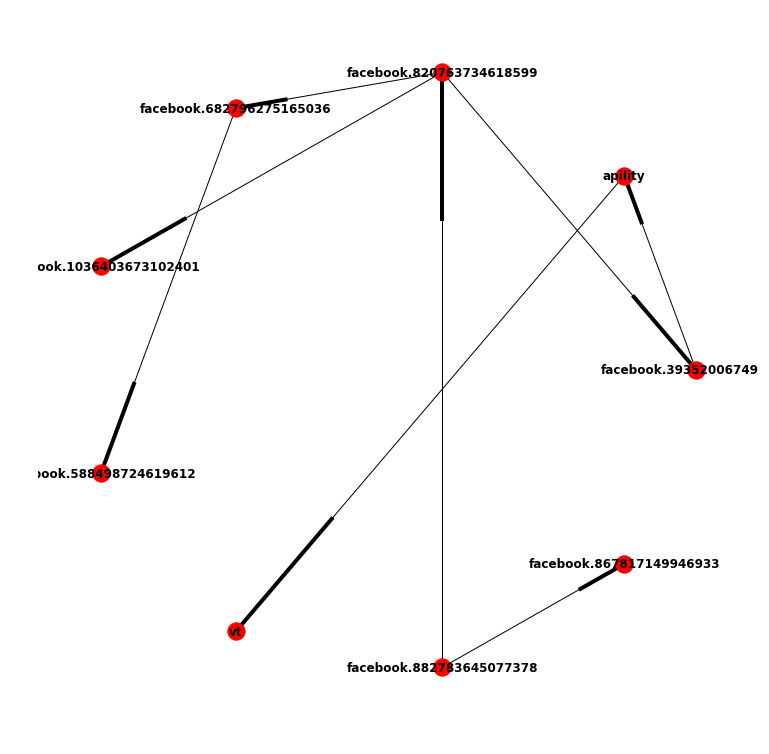

In [82]:
plt.figure(figsize=(10,10))
nx.draw_circular(gr, with_labels=True, font_weight='bold')
plt.show()

In [80]:
nx.nx_agraph.write_dot(gr, "blacklists.dot")